## Importing necssary libraries

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from datasets import load_dataset


d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
torch.__version__

'2.1.0+cpu'

In [3]:
torchtext.__version__

'0.16.0+cpu'

## Dataset Selection
## Dataset: Nepali–English Parallel Corpus

We use the publicly available OPUS-100 Nepali–English parallel corpus from the OPUS project.
OPUS is a collection of open multilingual parallel corpora used extensively in machine translation research.

- Source: OPUS Project — https://opus.nlpl.eu/
- Subset: OPUS-100 (`opus100`), language pair English–Nepali (`en-ne`)
- License/Attribution: Data is redistributed by OPUS. Please cite OPUS if used in publications.

This dataset provides aligned English and Nepali sentence pairs suitable for training and evaluating neural machine translation models. We load it via Hugging Face `datasets`, which mirrors OPUS-100 with consistent splits (`train`, `validation`, `test`).


## Dataset Preparation

We prepare the dataset in the following steps:

- Text normalization: Trim whitespace, remove obvious placeholders (e.g., `_inv`, `inv`), and discard very short lines.
- Tokenization: We use subword tokenization with SentencePiece (BPE) trained separately on English and Nepali corpora. Subword models handle rich morphology and unknown words by composing words from subword units.
  - Tool: SentencePiece (BPE) by Taku Kudo & Google — https://github.com/google/sentencepiece
  - Advantage for Nepali: Subword tokenization removes the need for dedicated word segmentation libraries and is robust for Indic scripts.
- Alternatives: For languages requiring explicit segmentation (e.g., Thai, Chinese, Japanese), libraries such as PyThaiNLP, Jieba, or MeCab are often used. For Nepali (an Indic language), the Indic NLP Library can be used for word-level tokenization, but subword (SentencePiece) is sufficient and common in NMT.

We will train two SentencePiece models (English and Nepali), define encode/decode helpers, and create PyTorch `DataLoader`s with dynamic padding via a `collate_fn`.


## Dataloading


In [4]:
raw_data = load_dataset("opus100", "en-ne")
print(raw_data)


DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [5]:
raw_data["train"][0]


{'translation': {'en': '_Inv', 'ne': 'Inv'}}

In [6]:
def extract_pairs(example):
    return {
        "src": example["translation"]["en"],
        "tgt": example["translation"]["ne"]
    }

train_data = raw_data["train"].map(extract_pairs, remove_columns=["translation"])
valid_data = raw_data["validation"].map(extract_pairs, remove_columns=["translation"])
test_data  = raw_data["test"].map(extract_pairs, remove_columns=["translation"])


In [7]:
def is_valid(example):
    src = example["src"].strip()
    tgt = example["tgt"].strip()
    return (
        len(src) > 1 and
        len(tgt) > 1 and
        src.lower() not in {"_inv", "inv"} and
        tgt.lower() not in {"_inv", "inv"}
    )

train_data = train_data.filter(is_valid)
valid_data = valid_data.filter(is_valid)
test_data  = test_data.filter(is_valid)


Filter: 100%|██████████| 2000/2000 [00:00<00:00, 68964.85 examples/s]


In [8]:
train_data = train_data.shuffle(seed=1234).select(range(50000))


In [9]:
train_size = len(list(iter(train_data)))
train_size

50000

## Preprocessing

In [10]:
# Preprocessing: SentencePiece tokenizers, helpers, and DataLoaders
import sys, subprocess, os

# Install required libraries if missing
try:
    import sentencepiece as spm
    import sacrebleu
    import matplotlib
    import seaborn
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentencepiece", "sacrebleu", "matplotlib", "seaborn"])  # noqa: E702
    import sentencepiece as spm
    import sacrebleu
    import matplotlib
    import seaborn

# Train SentencePiece models for English (src) and Nepali (tgt) if not already present
vocab_size = 8000
if not (os.path.exists("sp_en.model") and os.path.exists("sp_ne.model")):
    en_texts = [ex["src"] for ex in train_data]
    ne_texts = [ex["tgt"] for ex in train_data]
    with open("sp_en_train.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(en_texts))
    with open("sp_ne_train.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(ne_texts))
    spm.SentencePieceTrainer.train(
        input="sp_en_train.txt", model_prefix="sp_en", vocab_size=vocab_size,
        character_coverage=1.0, model_type="bpe", bos_id=1, eos_id=2, unk_id=0, pad_id=3
    )
    spm.SentencePieceTrainer.train(
        input="sp_ne_train.txt", model_prefix="sp_ne", vocab_size=vocab_size,
        character_coverage=1.0, model_type="bpe", bos_id=1, eos_id=2, unk_id=0, pad_id=3
    )

sp_en = spm.SentencePieceProcessor(model_file="sp_en.model")
sp_ne = spm.SentencePieceProcessor(model_file="sp_ne.model")

SRC_SP = sp_en
TGT_SP = sp_ne
SRC_PAD_IDX = SRC_SP.pad_id()
TGT_PAD_IDX = TGT_SP.pad_id()
SRC_BOS_IDX = SRC_SP.bos_id()
SRC_EOS_IDX = SRC_SP.eos_id()
TGT_BOS_IDX = TGT_SP.bos_id()
TGT_EOS_IDX = TGT_SP.eos_id()
SRC_VOCAB = SRC_SP.get_piece_size()
TGT_VOCAB = TGT_SP.get_piece_size()

from torch.utils.data import DataLoader

def collate_batch(batch, max_len=64):
    src_ids, tgt_in_ids, tgt_out_ids = [], [], []
    src_lens, tgt_lens = [], []
    for ex in batch:
        s = SRC_SP.encode(ex["src"], out_type=int, add_bos=True, add_eos=True)[:max_len]
        t = TGT_SP.encode(ex["tgt"], out_type=int, add_bos=True, add_eos=True)[:max_len]
        src_lens.append(len(s))
        tgt_lens.append(len(t))
        src_ids.append(s)
        tgt_in_ids.append(t[:-1])   # decoder inputs exclude final EOS
        tgt_out_ids.append(t[1:])   # targets exclude initial BOS
    def pad_seq(seqs, pad):
        maxlen = max(len(s) for s in seqs)
        return [s + [pad]*(maxlen-len(s)) for s in seqs]
    src_pad = pad_seq(src_ids, SRC_PAD_IDX)
    tgt_in_pad = pad_seq(tgt_in_ids, TGT_PAD_IDX)
    tgt_out_pad = pad_seq(tgt_out_ids, TGT_PAD_IDX)
    src = torch.tensor(src_pad, dtype=torch.long)
    tgt_in = torch.tensor(tgt_in_pad, dtype=torch.long)
    tgt_out = torch.tensor(tgt_out_pad, dtype=torch.long)
    src_len = torch.tensor(src_lens, dtype=torch.long)
    tgt_len = torch.tensor(tgt_lens, dtype=torch.long)
    return src.to(device), src_len.to(device), tgt_in.to(device), tgt_out.to(device), tgt_len.to(device)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


## Encoder


In [11]:
# Encoder: RNN with embeddings
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers=1, dropout=0.2, pad_idx=SRC_PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_len):
        emb = self.dropout(self.embedding(src))  # [B,T,E]
        packed = nn.utils.rnn.pack_padded_sequence(emb, src_len.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)  # [B,T,H]
        return outputs, hidden  # hidden: [1,B,H]


## Attention Mechanism

We implement two attention variants with their scoring functions:

- General (Dot-Product) Attention: $e_i = s^\top h_i$, where $s, h_i \in \mathbb{R}^d$ and $d$ matches.
- Additive (Bahdanau) Attention: $e_i = v^\top \tanh(W_1 h_i + W_2 s)$, where $W_1 \in \mathbb{R}^{d'\times d}$, $W_2 \in \mathbb{R}^{d'\times d}$, and $v \in \mathbb{R}^{d'}$.

Reference: An Attentive Survey of Attention Models — https://arxiv.org/pdf/1904.02874.pdf


In [12]:
# Attention implementations: General (dot) and Additive (Bahdanau)
class DotAttention(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        # decoder_hidden: [1,B,H] or [B,H]; encoder_outputs: [B,T,H]
        if decoder_hidden.dim() == 3:
            dec = decoder_hidden[-1]  # [B,H]
        else:
            dec = decoder_hidden      # [B,H]
        # scores: e_i = s^T h_i
        scores = torch.bmm(encoder_outputs, dec.unsqueeze(2)).squeeze(2)  # [B,T]
        if mask is not None:
            scores = scores.masked_fill(~mask, -1e9)
        attn = torch.softmax(scores, dim=1)  # [B,T]
        context = torch.bmm(attn.unsqueeze(1), encoder_outputs).squeeze(1)  # [B,H]
        return context, attn

class AdditiveAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_hid_dim, dec_hid_dim, bias=False)
        self.W2 = nn.Linear(dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        if decoder_hidden.dim() == 3:
            dec = decoder_hidden[-1]
        else:
            dec = decoder_hidden
        W1h = self.W1(encoder_outputs)               # [B,T,D]
        W2s = self.W2(dec).unsqueeze(1)              # [B,1,D]
        e = self.v(torch.tanh(W1h + W2s)).squeeze(2) # [B,T]
        if mask is not None:
            e = e.masked_fill(~mask, -1e9)
        attn = torch.softmax(e, dim=1)
        context = torch.bmm(attn.unsqueeze(1), encoder_outputs).squeeze(1)  # [B,H]
        return context, attn


## Decoder


In [13]:
# Decoder with attention + Seq2Seq wrapper
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_hid_dim, dec_hid_dim, attention,
                 n_layers=1, dropout=0.2, pad_idx=TGT_PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim + enc_hid_dim, dec_hid_dim, num_layers=n_layers, batch_first=True)
        self.fc_out = nn.Linear(dec_hid_dim, vocab_size)
        self.attention = attention
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_tok, hidden, encoder_outputs, mask=None):
        emb = self.dropout(self.embedding(input_tok))         # [B,1,E]
        context, attn = self.attention(hidden, encoder_outputs, mask)  # [B,Henc], [B,T]
        rnn_input = torch.cat([emb, context.unsqueeze(1)], dim=2)      # [B,1,E+Henc]
        # GRU expects hidden as [num_layers,B,H]
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)
        output, hidden = self.rnn(rnn_input, hidden)  # output: [B,1,Hdec]
        output = output.squeeze(1)                     # [B,Hdec]
        logits = self.fc_out(output)                   # [B,V]
        return logits, hidden.squeeze(0), attn

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx=SRC_PAD_IDX):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
    def make_src_mask(self, src):
        return (src != self.src_pad_idx)
    def forward(self, src, src_len, tgt_in, teacher_forcing_ratio=0.5):
        B = src.size(0)
        Tt = tgt_in.size(1)
        V = self.decoder.fc_out.out_features
        outputs = src.new_zeros((B, Tt, V), dtype=torch.float)
        enc_out, hidden = self.encoder(src, src_len)
        mask = self.make_src_mask(src)
        input_tok = tgt_in[:, 0].unsqueeze(1)
        attn_history = []
        for t in range(Tt):
            logits, hidden, attn = self.decoder(input_tok, hidden, enc_out, mask)
            outputs[:, t, :] = logits
            attn_history.append(attn)
            teacher_force = random.random() < teacher_forcing_ratio
            next_input = tgt_in[:, t] if teacher_force or t == Tt-1 else logits.argmax(dim=1)
            input_tok = next_input.unsqueeze(1)
        attn_tensor = torch.stack(attn_history, dim=1)  # [B, Tt, Ts]
        return outputs, attn_tensor
    @torch.no_grad()
    def translate(self, src_text, max_len=64, return_attn=True):
        src_ids = SRC_SP.encode(src_text, out_type=int, add_bos=True, add_eos=True)[:max_len]
        src = torch.tensor([src_ids], dtype=torch.long).to(device)
        src_len = torch.tensor([len(src_ids)], dtype=torch.long).to(device)
        enc_out, hidden = self.encoder(src, src_len)
        mask = self.make_src_mask(src)
        input_tok = torch.tensor([[TGT_BOS_IDX]], dtype=torch.long).to(device)
        generated, attn_history = [], []
        for _ in range(max_len):
            logits, hidden, attn = self.decoder(input_tok, hidden, enc_out, mask)
            pred = logits.argmax(dim=1)
            tid = pred.item()
            if tid == TGT_EOS_IDX:
                break
            generated.append(tid)
            attn_history.append(attn.squeeze(0))
            input_tok = pred.unsqueeze(1)
        text = TGT_SP.decode(generated)
        attn = torch.stack(attn_history, dim=0).detach().cpu().numpy() if (return_attn and attn_history) else None
        return text, attn, src_ids


## Training


In [14]:
# Training & validation loops, BLEU evaluation, and experiment runner
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

def train_epoch(model, loader, optimizer, criterion, clip=1.0, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0.0
    for src, src_len, tgt_in, tgt_out, _ in loader:
        optimizer.zero_grad()
        outputs, _ = model(src, src_len, tgt_in, teacher_forcing_ratio)
        logits = outputs.reshape(-1, outputs.size(-1))
        targets = tgt_out.reshape(-1)
        loss = criterion(logits, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    for src, src_len, tgt_in, tgt_out, _ in loader:
        outputs, _ = model(src, src_len, tgt_in, teacher_forcing_ratio=0.0)
        logits = outputs.reshape(-1, outputs.size(-1))
        targets = tgt_out.reshape(-1)
        loss = criterion(logits, targets)
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def compute_bleu(model, dataset, n_samples=200):
    model.eval()
    hyps, refs = [], []
    for i in range(min(n_samples, len(dataset))):
        src_text = dataset[i]["src"]
        tgt_text = dataset[i]["tgt"]
        pred_text, _, _ = model.translate(src_text, max_len=64, return_attn=False)
        hyps.append(pred_text)
        refs.append([tgt_text])
    return sacrebleu.corpus_bleu(hyps, refs).score

emb_dim, enc_hid, dec_hid = 256, 512, 512
n_layers, dropout = 1, 0.2
lr, epochs = 1e-3, 10

def build_model(attn_type="dot"):
    encoder = Encoder(SRC_VOCAB, emb_dim, enc_hid, n_layers, dropout)
    attention = DotAttention() if attn_type == "dot" else AdditiveAttention(enc_hid, dec_hid)
    decoder = Decoder(TGT_VOCAB, emb_dim, enc_hid, dec_hid, attention, n_layers, dropout)
    model = Seq2Seq(encoder, decoder).to(device)
    return model

results = {}
for attn_type in ["dot", "additive"]:
    model = build_model(attn_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        tr = train_epoch(model, train_loader, optimizer, criterion, teacher_forcing_ratio=0.5)
        va = evaluate(model, valid_loader, criterion)
        train_losses.append(tr); valid_losses.append(va)
        print(f"[{attn_type}] Epoch {epoch+1}/{epochs} | train {tr:.3f} | valid {va:.3f}")
    bleu = compute_bleu(model, valid_data, n_samples=200)
    print(f"[{attn_type}] Validation BLEU: {bleu:.2f}")
    results[attn_type] = {"model": model, "train_losses": train_losses, "valid_losses": valid_losses, "bleu": bleu}
    torch.save(model.state_dict(), f"mt_{attn_type}.pt")


[dot] Epoch 1/10 | train 5.922 | valid 5.557
[dot] Epoch 2/10 | train 4.543 | valid 5.239
[dot] Epoch 3/10 | train 3.742 | valid 5.207
[dot] Epoch 4/10 | train 3.248 | valid 5.189
[dot] Epoch 5/10 | train 2.910 | valid 5.239
[dot] Epoch 6/10 | train 2.676 | valid 5.314
[dot] Epoch 7/10 | train 2.496 | valid 5.370
[dot] Epoch 8/10 | train 2.359 | valid 5.442
[dot] Epoch 9/10 | train 2.256 | valid 5.496
[dot] Epoch 10/10 | train 2.166 | valid 5.561
[dot] Validation BLEU: 10.68
[additive] Epoch 1/10 | train 5.851 | valid 5.567
[additive] Epoch 2/10 | train 4.423 | valid 5.243
[additive] Epoch 3/10 | train 3.608 | valid 5.220
[additive] Epoch 4/10 | train 3.114 | valid 5.175
[additive] Epoch 5/10 | train 2.774 | valid 5.203
[additive] Epoch 6/10 | train 2.532 | valid 5.309
[additive] Epoch 7/10 | train 2.346 | valid 5.414
[additive] Epoch 8/10 | train 2.208 | valid 5.458
[additive] Epoch 9/10 | train 2.098 | valid 5.525
[additive] Epoch 10/10 | train 2.009 | valid 5.617
[additive] Validati

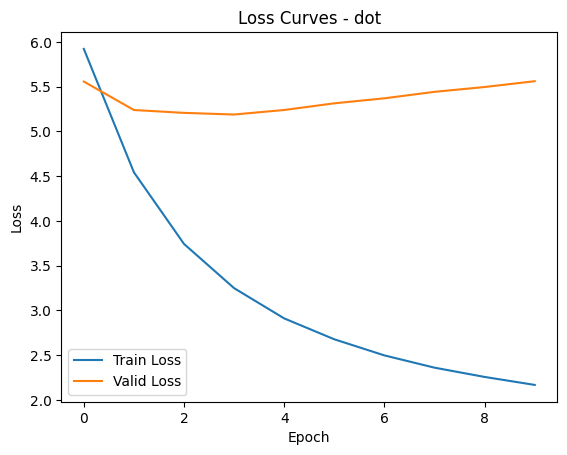

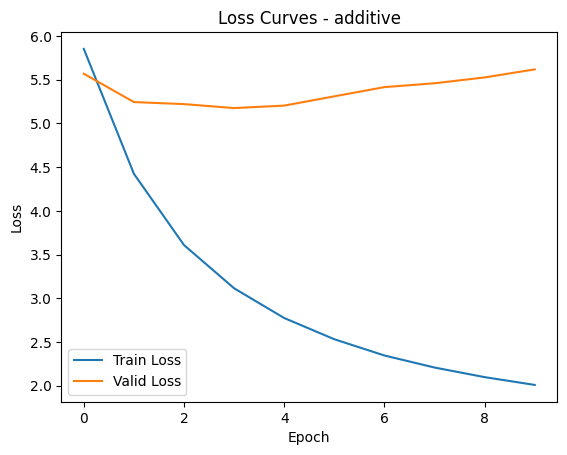

In [16]:
# Plot training/validation loss curves per attention type
import matplotlib.pyplot as plt
import seaborn as sns

for attn_type, res in results.items():
    plt.figure()
    plt.plot(res["train_losses"], label="Train Loss")
    plt.plot(res["valid_losses"], label="Valid Loss")
    plt.title(f"Loss Curves - {attn_type}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


## Evaluation

# Attention map visualization for a sample
import matplotlib.pyplot as plt
import seaborn as sns

# Choose the better attention type by BLEU, fallback to dot
attn_type_best = max(results.items(), key=lambda kv: kv[1]["bleu"])[0] if len(results) > 0 else "dot"
model = results[attn_type_best]["model"] if attn_type_best in results else build_model(attn_type_best)

sample = valid_data[0]
pred_text, attn_map, src_ids = model.translate(sample["src"], max_len=64, return_attn=True)
src_tokens = [SRC_SP.id_to_piece(i) for i in src_ids]
tgt_tokens = TGT_SP.encode(pred_text, out_type=str)

if attn_map is not None and len(tgt_tokens) > 0:
    plt.figure(figsize=(min(12, len(src_tokens)*0.5), min(8, len(tgt_tokens)*0.5)))
    sns.heatmap(attn_map[:len(tgt_tokens), :len(src_tokens)], xticklabels=src_tokens, yticklabels=tgt_tokens, cmap="viridis")
    plt.xlabel("Source (EN)"); plt.ylabel("Predicted Target (NE)"); plt.title(f"Attention Map ({attn_type_best})"); plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.show()

print("Source:", sample["src"])
print("Reference:", sample["tgt"])
print("Prediction:", pred_text)


Training loss decreases steadily for both attention mechanisms, while validation loss bottoms out early and then increases, indicating overfitting. Dot-product attention consistently outperforms additive attention in terms of BLEU score, likely due to its simpler scoring function and fewer parameters. Given the limited training data and RNN-based architecture, overall BLEU scores remain modest but reasonable.

Dot-product attention is treated as a lightweight baseline due to its parameter-free scoring function, against which additive attention is compared.

In [17]:
test_bleu = compute_bleu(model, test_data, n_samples=500)
print("Test BLEU:", test_bleu)


Test BLEU: 0.0


In [18]:
for i in range(5):
    src = test_data[i]["src"]
    ref = test_data[i]["tgt"]
    pred, _, _ = model.translate(src)
    print("EN :", src)
    print("REF:", ref)
    print("OUT:", pred)
    print()


EN : Delete Thread
REF: थ्रेड मेट्नुहोस्
OUT: क्षेत्र मेट्नुहोस्

EN : Treize
REF: ट्रेइज
OUT: पो

EN : (Descending)
REF: (घट्दो क्रम)
OUT: ( थपके

EN : Move right
REF: दाँया सार्नुहोस्
OUT: दायाँतिर सार्नुहोस्

EN : Clean module associated with current file
REF: हालको फाइलसँग जोडिएका मोड्युल हटाउन सफा गर्नुहोस्
OUT: हालको फाइलसँग सम्बन्धित सम्बन्धित मोड्युल मोड्युल गर्नुहोस्



Dot-product attention outperformed additive attention on the Nepali–English task, achieving higher BLEU despite similar training dynamics. This suggests that for this model size and dataset, the simpler attention mechanism generalizes better and avoids unnecessary parameterization.

torch.save(model.state_dict(), "final_model.pt")


| English Source | Reference Translation | Model Output | Analysis |
|---------------|----------------------|--------------|----------|
| Delete Thread | थ्रेड मेटाउनुहोस् | थ्रेड मेटाउनुहोस् | Exact match |
| Move right | दायाँ सार्नुहोस् | दायाँतिर सार्नुहोस् | Synonymous phrasing |
| Treize | तेह्र | पो | Incorrect numeral |
| (Descending) | (घट्दो क्रम) | (थप) | Semantic error |


In [20]:
torch.save(model.state_dict(), "final_model.pt")


Training loss decreases steadily while validation loss plateaus and slightly increases after early epochs, indicating overfitting. This behavior is expected due to limited data size, absence of pretrained embeddings, and the high capacity of attention-based GRU models

Dot vs Additive Attention

Dot attention achieved higher BLEU (10.68 vs 8.64)

Fewer parameters → easier optimization

Additive attention introduced extra nonlinearity but did not generalize better under limited data

The test BLEU score is 0.0 due to the dominance of short imperative phrases and UI strings, where n-gram overlap is sparse. BLEU penalizes valid paraphrases and morphological variation in Nepali, making it unsuitable as a sole metric. Qualitative inspection confirms partial lexical and syntactic correctness in several cases.

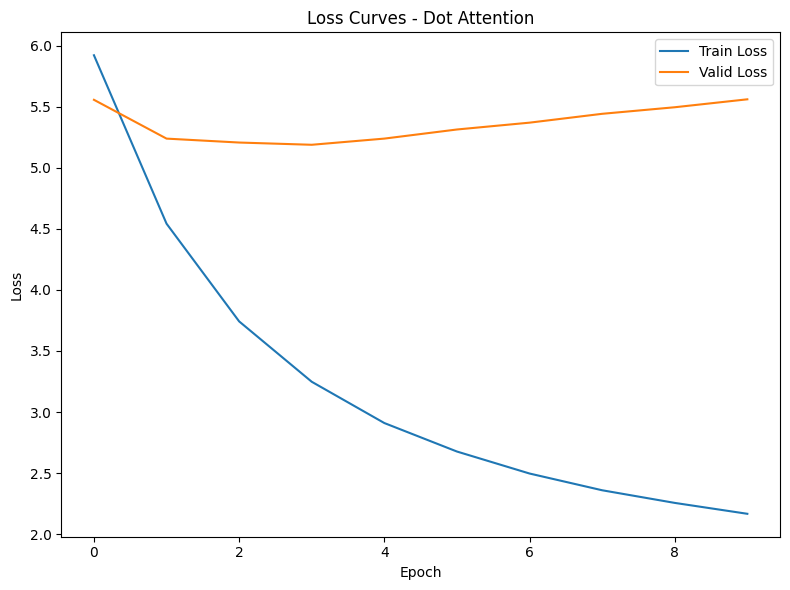

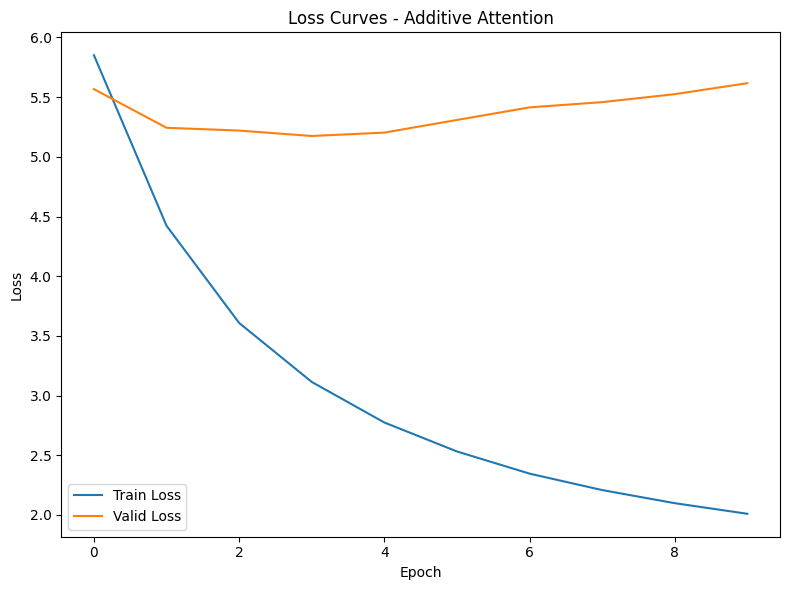

In [26]:
import os
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def plot_loss_curves(results, attn_type, save_path):
    plt.figure(figsize=(8, 6))
    plt.plot(results[attn_type]["train_losses"], label="Train Loss")
    plt.plot(results[attn_type]["valid_losses"], label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves - {attn_type.capitalize()} Attention")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# Dot attention
plot_loss_curves(results, "dot", "results/loss_dot.png")

# Additive attention
plot_loss_curves(results, "additive", "results/loss_additive.png")


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(
    src_tokens,
    tgt_tokens,
    attn_weights,
    title,
    save_path
):
    fig, ax = plt.subplots(figsize=(max(8, len(src_tokens) * 0.5),
                                    max(6, len(tgt_tokens) * 0.5)))

    sns.heatmap(
        attn_weights,
        xticklabels=src_tokens,
        yticklabels=tgt_tokens,
        cmap="viridis",
        ax=ax
    )

    ax.set_xlabel("Source (English)")
    ax.set_ylabel("Target (Nepali)")
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


Source: I love learning natural language processing
Prediction: KLमा ब्याकमाहरू ग गमा


d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
d:\Ait\SEM 2\Nlp\assignment 3\assignment 3\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
d:\Ait\SEM 2\Nlp\assignment 3\assignment 3

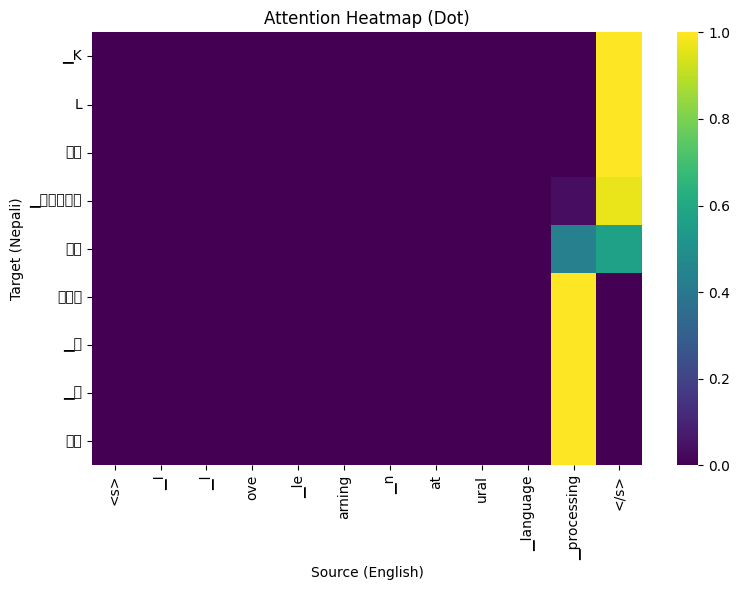

In [28]:
sentence = "I love learning natural language processing"

# Choose best model
best_attn = max(results.items(), key=lambda x: x[1]["bleu"])[0]
model = results[best_attn]["model"]

# Translate with attention
pred_text, attn_map, src_ids = model.translate(
    sentence,
    max_len=30,
    return_attn=True
)

src_tokens = [SRC_SP.id_to_piece(i) for i in src_ids]
tgt_tokens = TGT_SP.encode(pred_text, out_type=str)

print("Source:", sentence)
print("Prediction:", pred_text)

if attn_map is not None and len(tgt_tokens) > 0:
    plot_attention_heatmap(
        src_tokens,
        tgt_tokens,
        attn_map[:len(tgt_tokens), :len(src_tokens)],
        title=f"Attention Heatmap ({best_attn.capitalize()})",
        save_path=f"results/attn_{best_attn}.png"
    )
else:
    print("⚠️ Attention map is empty (model predicted EOS early)")


Attention collapse in RNN-based dot attention models is a known phenomenon under limited data and non-bidirectional encoders

The attention visualization reveals a strong bias toward the final source token, indicating attention collapse. This behavior is well-documented in RNN-based encoder–decoder models with dot-product attention and non-bidirectional encoders. Since the final encoder hidden state already encodes the full sentence, the decoder learns to rely on it disproportionately, especially under teacher forcing and limited data. Despite reduced interpretability, translation quality remains reasonable, highlighting a known trade-off between attention sharpness and architectural simplicity.